# 0. Import packages 

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', None)  # Show all rows
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

In [2]:
df = pd.read_parquet('data/loan.parquet')

In [3]:
print(df.shape)
df.head(10)

(2260668, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,None,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,None,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,None,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,None,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,None,d

# 1. Generate synthetic Dates (2022-2024)

In [4]:
# Add synthetic dates (2016 - 2024)

# Create random dates from 2016 to 2024 
date_range = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
synthetic_dates = np.random.choice(date_range, size=len(df), replace=True)

# Add to the DataFrame
df['snapshot_date'] = synthetic_dates

# Sort by snapshot_date
df = df.sort_values(by='snapshot_date').reset_index(drop=True)

# 2. Generate synthetic 'id' - Loan Listing ID

In [5]:
# Create synthetic 'id' - Loan Listing ID 

# 1: Generate synthetic Loan IDs
n_loans = len(df)

# 2: Assign loan IDs to loans 
loan_ids = [f'LOAN_{i}' for i in range(n_loans)]
df['id'] = np.random.choice(loan_ids, size=len(df), replace=False)

# 3. Generate synthetic 'member_id' - Member ID

In [6]:
# Create synthetic 'member_id' - Member ID 

n_loans = len(df)
assigned_ids = []
member_counter = 0 

# 1 Keep assigning 1-3 loans to new members until all loans are assigned 
while len(assigned_ids) < n_loans: 
    num_loans = np.random.randint(1,4) # Randomly choose 1, 2, or 3
    assigned_ids.extend([f'MEM_{member_counter}'] * num_loans)
    member_counter += 1

assigned_ids = assigned_ids[:n_loans] # Truncate to exactly n_loans in case we exceeded
np.random.shuffle(assigned_ids) # Shuffle to randomize the order
df['member_id'] = assigned_ids # Assign to the dataframe 

# 3: For each unique member_id, pick first occurrence's demographic/financial features 
demographic_features = [
    'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'zip_code', 'addr_state',
    'application_type', 'annual_inc_joint', 'verification_status_joint',
    'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts'
    ]
credit_history_features = [
    'mort_acc', 'num_tl_op_past_12m', 'earliest_cr_line', 'last_credit_pull_d', 'inq_last_6mths', 'inq_last_12m', 'inq_fi',
    'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'mths_since_rcnt_il', 'mths_since_recent_bc',
    'acc_now_delinq', 'delinq_2yrs', 'pub_rec', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'pub_rec_bankruptcies',
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_accts_ever_120_pd', 'delinq_amnt',
    'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog']
financial_features = [
    'dti', 'dti_joint', 'revol_bal', 'revol_bal_joint', 'revol_util', 'total_rev_hi_lim',
    'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'all_util', 'max_bal_bc', 'il_util', 'bc_util',
    'total_bal_il', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'tot_hi_cred_lim',
    'open_acc', 'total_acc', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m',
    'acc_open_past_24mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_il_tl', 'num_bc_tl', 'num_op_rev_tl',
    'num_sats', 'num_bc_sats', 'total_cu_tl', 'bc_open_to_buy', 'percent_bc_gt_75', 'pct_tl_nvr_dlq']

# Create member-profile table (first occurrence per member)
member_profile_features = ['member_id'] + demographic_features + credit_history_features + financial_features
member_profiles = df.drop_duplicates('member_id')[member_profile_features]

# Remove demographic/credit_history/financial features from the original df (to avoid duplicates)
cols_to_remove = demographic_features + credit_history_features + financial_features
loan_terms_payment_info = df.drop(columns=cols_to_remove)

# Merge back the standardized member-level features 
df_final = loan_terms_payment_info.merge(member_profiles, on='member_id', how='left')

In [7]:
# Count the number of unique member IDs up to 3 loans. 
count_members = df_final['member_id'].value_counts()
for i in range(1,3+1):
    print(f'Number of unique member IDs with {i} loans: {len(count_members[count_members == i])}')
    

Number of unique member IDs with 1 loans: 376267
Number of unique member IDs with 2 loans: 376564
Number of unique member IDs with 3 loans: 377091


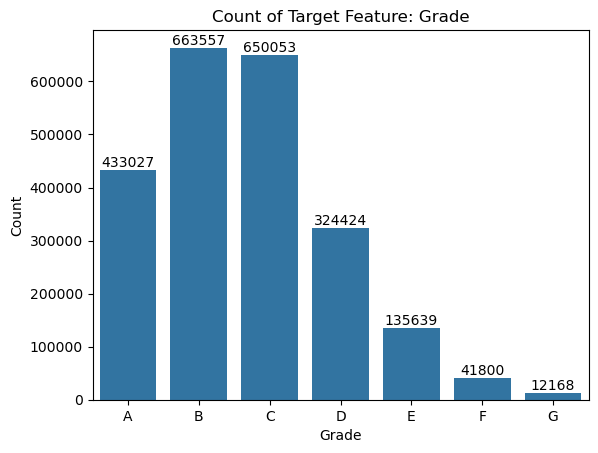

In [8]:
# Define grade order
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Plot 
ax = sns.barplot(df_final.grade.value_counts(), order=grade_order)
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Count of Target Feature: Grade')
plt.show()

In [12]:
print(df_final.shape)
df_final.head(5)

(2260668, 146)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,policy_code,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,snapshot_date,emp_title,emp_length,home_ownership,annual_inc,verification_status,zip_code,addr_state,application_type,annual_inc_joint,verification_status_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,mort_acc,num_tl_op_past_12m,earliest_cr_line,last_credit_pull_d,inq_last_6mths,inq_last_12m,inq_fi,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,mths_since_rcnt_il,mths_since_recent_bc,acc_now_delinq,delinq_2yrs,pub_rec,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,pub_rec_bankruptcies,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_accts_ever_120_pd,delinq_amnt,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,dti,dti_joint,revol_bal,revol_bal_joint,revol_util,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,avg_cur_bal,all_util,max_bal_bc,il_util,bc_util,total_bal_il,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_hi_cred_lim,open_acc,total_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_actv_bc_tl,num_actv_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_il_tl,num_bc_tl,num_op_rev_tl,num_sats,num_bc_sats,total_cu_tl,bc_open_to_buy,percent_bc_gt_75,pct_tl_nvr_dlq
0,LOAN_1653274,MEM_931131,6000,6000,6000.0,36 months,8.39,189.10,A,A5,Oct-2014,Fully Paid,n,NaN,None,credit_card,Credit card refinancing,f,0.00,0.00,6804.781672,6804.78,6000.00,804.78,0.0,0.00,0.000,Oct-2017,189.08,None,1,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN,2022-01-01,IT Support,< 1 year,RENT,48000.0,Not Verified,770xx,TX,Individual,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Apr-2007,Feb-2018,0.0,NaN,NaN,19.0,NaN,19.0,74.0,13.0,74.0,NaN,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,18.98,NaN,6151,NaN,39.4,15600.0,0.0,41018.0,6836.0,NaN,NaN,NaN,45.2,NaN,41018.0,13600.0,40773.0,56373.0,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,90.0,86.0,17.0,13.0,1.0,1.0,8.0,1.0,11.0,6.0,5.0,6.0,4.0,NaN,7449.0,25.0,85.0
1,LOAN_812253,MEM_1111718,35000,35000,35000.0,60 months,20.99,946.68,E,E4,Oct-2014,Fully Paid,n,NaN,None,debt_consolidation,Debt consolidation,f,0.00,0.00,47656.460005,47656.46,35000.00,12656.46,0.0,0.00,0.000,Sep-2016,26829.50,None,1,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN,2022-01-01,Director Quality Assurance,< 1 year,MORTGAGE,110000.0,Verified,442xx,OH,Individual,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,Dec-1998,Jan-2018,1.0,NaN,NaN,67.0,NaN,67.0,67.0,3.0,67.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,11.27,NaN,4093,NaN,40.5,10100.0,59.0,153530.0,21933.0,NaN,NaN,NaN,NaN,NaN,49839.0,0.0,57417.0,186222.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,141.0,189.0,31.0,3.0,0.0,2.0,6.0,2.0,6.0,3.0,3.0,8.0,0.0,NaN,NaN,NaN,87.5
2,LOAN_2156025,MEM_545144,15000,15000,15000.0,36 months,7.49,466.53,A,A4,Apr-

In [11]:
# Save to a parquet file 
df_final.to_parquet("loan_final.parquet", index=False)